In [1]:
# Append path for package
import sys
sys.path.append("../mosaic_underice_sunlight/")

from pathlib import Path
import re

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from mosaic_thickness import snowdepth_file, parse_raw_combined_data, MAGNAPROBE_PATH, get_filename
from plotting import plot_thickness_profile

filepath = Path('../data/mosaic-transect-actionlog-updated.xlsx')

transect_id_pattern = r"^\s*PS-*122[_/-]\d[_-]\d{1,2}-\d{1,3}\s*$"

## Parse MOSAiC transect action log

This file contains a lot of information but is not in a very friendly format for automated processing.  It will need reformatting to take full benefit of the information.  However, for now, I just want the names of Magnaprobe transects that have both GEM-2 ice thickness and Magnaprobe snow depths.

In [2]:
def is_leg(v):
    if isinstance(v, str):
        if "LEG" in v:
            return True
    return False

def get_leg_id(v):
    if is_leg(v):
        return int(v.split()[1])
    else:
        np.nan

In [3]:
df = pd.read_excel(filepath, index_col=0, parse_dates=False)
# Rename columns to get rid of whitespace, parenthesis and '.'
newcol = []
for col in df.columns:
    newcol.append('_'.join([s.lower().replace('(','').replace(')','').replace('.','').replace('-','') for s in re.split(' | \n|\n', col) if s != '']))
df.columns = newcol

# Fill index - this avoids rows with LEG
df.index = df.index.to_series().ffill().values

# Add a column with Leg ID
df["leg_id"] = df.index.map(get_leg_id).to_series().ffill().values

# Drop columns with LEG in index
df.drop(df.index[df.index.map(is_leg)], inplace=True)

# Convert index to DatetimeIndex
df.index = pd.to_datetime(df.index)

df = df[['ice+snow_locations', 'gem2_ice_thickness', 'magnaprobe_snow_depth']]

In [4]:
df.head()

,ice+snow_locations,gem2_ice_thickness,magnaprobe_snow_depth
2019-10-24,Northern Loop,PS122/1_4-2,PS122/1_4-1
2019-10-24,Calibration,PS122/1_4-3,NaN
2019-10-31,Northern Loop,PS122/1_5-25,PS122/1_5-27
2019-10-31,Southern Loop,NaN,NaN
2019-10-31,Calibration,PS122/1_6-26,NaN


In [5]:
df.loc["2020-09-04"]

ice+snow_locations                                            Ridge survey
gem2_ice_thickness                                          PS122/5_60-162
magnaprobe_snow_depth    N/A - see spreadsheet titled "RidgeSurvey_Snow...
Name: 2020-09-04 00:00:00, dtype: object

## Find GEM2 or Magnaprobe transects with more than one transect id

Some table entries contain multiple transect ids or notes.  I list these here.  For the moment, these transects are ignored

In [6]:
df[(df["gem2_ice_thickness"].str.match(transect_id_pattern) == False) |
   (df["magnaprobe_snow_depth"].str.match(transect_id_pattern) == False)]

,ice+snow_locations,gem2_ice_thickness,magnaprobe_snow_depth
2020-01-23,Long Transect & Lead Event,PS122-2_21-97,PS122-2_21-140\nPS122-2_21-141
2020-06-17,Floe surveys,PS122/4_44-225,PS122/4_44-265\nPS122/4_44-266
2020-07-21,"Transect Loop, 1 albedo line (LD).",PS122/4_48-61\nPS122/4_48-180,PS122/4_48-246
2020-07-24,Lemon Drop albedo line,PS122/4_48_274,PS122/4_48-248
2020-09-04,Ridge survey,PS122/5_60-162,"N/A - see spreadsheet titled ""RidgeSurvey_Snow..."


## Find Transects with both GEM-2 ice thickness and Magnaprobe snow depths

For now, I limit this to surveys with single transect files

In [7]:
df = df[df["gem2_ice_thickness"].str.match(transect_id_pattern) & df["magnaprobe_snow_depth"].str.match(transect_id_pattern)]
df

,ice+snow_locations,gem2_ice_thickness,magnaprobe_snow_depth
2019-10-24,Northern Loop,PS122/1_4-2,PS122/1_4-1
2019-10-31,Northern Loop,PS122/1_5-25,PS122/1_5-27
2019-11-07,Northern Loop,PS122/1_6-48,PS122/1_6-50
2019-11-14,Northern Loop\n,PS122/1_7-60,PS122/1_7-62
2019-11-21,Northern Loop,PS122/1_8-55,PS122/1_8-58
...,...,...,...
2020-09-18,Transect by Kinder albedo line,PS122/5_62-199,PS122/5_62-243
2020-09-19,Remote Sensing Site,PS122/5_62-194,PS122/5_62-244
2020-09-24,Ice Station 1: short & long transects,PS122/5_63-33,PS122/5_63-37
2020-09-26,Ice Station 2: short & long transects,PS122/5_63-68,PS122/5_63-80


## Find matching snow depth and ice thickness files

Combined magnaprobe and GEM2 files are under the MOSAIC_magnaprobe directory.  Data for each transect is in a directory with a name YYYYMMDD-PS122-L-XX-XX.

In [8]:
list(MAGNAPROBE_PATH.glob("*"))[:10]

[PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191024-PS122-1_4-1'),
 PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191031-PS122-1_5-27'),
 PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191107-PS122-1_6-50'),
 PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191114-PS122-1_7-62'),
 PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191121-PS122-1_8-58'),
 PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191128-PS122-1_9-54'),
 PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191205-PS122-1_10-59'),
 PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191219-PS122-2_16-83'),
 PosixPath('/home/apbarret/Data

The survey naming convention is different from the directory naming convention, so we have to fix this.  Annoyingly, the differences are not always consistent.

In [9]:
df["magnaprobe_snow_depth"].values

array(['PS122/1_4-1', 'PS122/1_5-27', 'PS122/1_6-50', 'PS122/1_7-62',
       'PS122/1_8-58', 'PS122/1_9-54', 'PS122-1_10-59', 'PS122-2_16-83',
       'PS122-2_16-84', 'PS122-2_17-113', 'PS122-2_18-80',
       'PS122-2_19-101', 'PS122-2_19-103', 'PS122-2_19-107',
       'PS122-2_19-110', 'PS122-2_19-113', 'PS122-2_19-139',
       'PS122-2_20-43', 'PS122-2_20-95', 'PS122-2-20-98',
       'PS122-2_21-142', 'PS122_2_22-92', 'PS122_2-22-94',
       ' PS122_2_23-62', 'PS-122-2_23-90', 'PS122_2_24-69',
       'PS122-2-25-119', 'PS122-2-25-122', 'PS122-2-25-124',
       'PS122-3_29-67', 'PS122-3_29-70', 'PS122-3_29-73', 'PS122-3_30-85',
       'PS122-3_30-88', 'PS122-3_30-89', 'PS122-3_32-95', 'PS122-3_33-91',
       'PS122-3_33-92', 'PS122-3_34-15', 'PS122-3_34-88', 'PS122-3_34-89',
       'PS122-3_35-20', 'PS122-3_35-21', 'PS122-3_35-112',
       'PS122-3_35-114', 'PS122-3_36-153', 'PS122-3_36-145',
       'PS122-3_37-82', 'PS122-3_37-83', 'PS122-3_37-84',
       'PS122-3_37-134', 'PS122-3_3

In [10]:
def fix_transect_id(s):
    """Fixes random formatting of transect ids"""
    rs = re.sub(r'(?<=PS122)/|(?<=PS122)_','-',s.strip())  # replace 
    rs = re.sub(r'(?<=PS122-\d)-','_',rs)
    rs = re.sub(r'(?<=PS)-','',rs)
    return rs

In [11]:
def unique_path(fp):
    return len(set([f.exists() for f in MAGNAPROBE_PATH.glob(fp)])) == 1

def contains_combined(fp):
    return len(list(MAGNAPROBE_PATH.glob(f"{fp}/magna+gem2*.csv")))

def get_path(fp):
    p = list(MAGNAPROBE_PATH.glob(f"{fp}"))
    if p:
        return p[0]
    else:
        None

In [12]:
filepath = [MAGNAPROBE_PATH / f for f in df.index.strftime("%Y%m%d").values + "-" + df["magnaprobe_snow_depth"].apply(fix_transect_id).values]
filepath = [f for f in filepath if f.exists()]
filepath[:5]

[PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191024-PS122-1_4-1'),
 PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191031-PS122-1_5-27'),
 PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191107-PS122-1_6-50'),
 PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191114-PS122-1_7-62'),
 PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191121-PS122-1_8-58')]

In [13]:
for datestr, transect in zip(df.index.strftime("%Y%m%d").values, df["magnaprobe_snow_depth"].apply(fix_transect_id).values):
    f = f"{datestr}*{transect}"
    print(f"{datestr}, {transect:15s} {str(unique_path(f)):5s} {str(contains_combined(f)):5s} {get_path(f)}")

20191024, PS122-1_4-1     True  1     /home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191024-PS122-1_4-1
20191031, PS122-1_5-27    True  2     /home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191031-PS122-1_5-27
20191107, PS122-1_6-50    True  2     /home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191107-PS122-1_6-50
20191114, PS122-1_7-62    True  2     /home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191114-PS122-1_7-62
20191121, PS122-1_8-58    True  1     /home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191121-PS122-1_8-58
20191128, PS122-1_9-54    True  1     /home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191128-PS122-1_9-54
20191205, PS122-1_10-59   True  2     /home/apbarret/Data/Sunlight_under_seaice/MOSAiC_Observations/raw/MOSAiC_magnaprobe/20191205-PS122-

Get a list of non-problematic filenames

In [14]:
# savefiles = []
# for fp in filepath:
#     try:
#         fn = get_filename(fp)
#         df = load_data(fn)
#         if (df.melt_pond_depth_m > 0.).any():
#             print(f"{fn}: Melt Pond!")
#         savefiles.append(fn)
#     except Exception as err:
#         pass
        #print(err)

In [15]:
# with open('../data/transect_filelist.txt', 'w') as f:
#     f.write('\n'.join([str(p) for p in savefiles]))

In [16]:
# df = load_data('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_magnaprobe/20200627-PS122-4_44-267/magna+gem2-transect-20200627_PS122-4_44-267_transect.csv')

In [17]:
# df.head()

In [18]:
# fig, ax = plt.subplots(figsize=(10,3))
# plot_thickness_profile(df, ax=ax)

## Read all combined transect files

In [19]:
files = [fp for fp in MAGNAPROBE_PATH.glob("*/magna+gem2-transect*.csv") if re.search(r"\d{8}_PS122-\d_\d*-\d*_", fp.name)]
len(files)

157

In [20]:
df = parse_raw_combined_data(files[100])
#df["melt_pond_depth_m"] = df["melt_pond_depth_m"].where(df["melt_pond_depth_m"] >= 0.)
df

,lon,lat,local_x,local_y,ice_thickness_m,snow_depth_m,melt_pond_depth_m,surface_type,transect_distance_m,ice_thickness_flag
Date/Time,,,,,,,,,,
2020-07-05 12:30:53,6.23038,81.69712,-150.103949,-71.886019,3.679757,0.08250,0.0,1,0.000000,1
2020-07-05 12:30:55,6.23050,81.69712,-152.139744,-71.721549,3.764059,0.05277,0.0,1,2.042427,1
2020-07-05 12:30:58,6.23070,81.69712,-153.918919,-70.203720,4.225757,0.07070,0.0,1,4.381074,1
2020-07-05 12:31:01,6.23081,81.69712,-156.809375,-67.692655,4.081557,0.08250,0.0,1,8.209936,1
2020-07-05 12:31:03,6.23100,81.69711,-158.701923,-66.235674,3.980430,0.04717,0.0,1,10.598352,1
...,...,...,...,...,...,...,...,...,...,...
2020-07-05 15:01:43,6.10170,81.68626,226.417182,-31.259610,1.585364,0.05615,0.0,1,3401.142539,1
2020-07-05 15:01:51,6.10161,81.68626,225.380414,-30.555543,1.756886,0.11780,0.0,1,3402.395774,1
2020-07-05 15:01:55,6.10160,81.68627,224.746821,-30.675418,1.774286,0.10040,0.0,2,3403.040608,1


In [21]:
df.describe()

,lon,lat,local_x,local_y,ice_thickness_m,snow_depth_m,melt_pond_depth_m,surface_type,transect_distance_m,ice_thickness_flag
count,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.0
mean,6.146005,81.694384,-60.507419,-510.607647,2.297591,0.066972,0.032599,0.757004,1747.237631,1.0
std,0.053333,0.005110,410.028507,339.057198,0.926189,0.053700,0.090818,0.805348,981.169961,0.0
min,6.086222,81.685830,-590.447565,-1027.520885,0.794186,0.000000,0.000000,-1.000000,0.000000,1.0
25%,6.098160,81.689000,-467.642237,-819.718671,1.569316,0.040450,0.000000,1.000000,905.448487,1.0
50%,6.125350,81.697070,-164.576356,-522.946070,2.067929,0.061740,0.000000,1.000000,1723.716225,1.0
75%,6.197090,81.698960,370.182581,-175.633336,2.829481,0.087000,0.000000,1.000000,2609.712082,1.0
max,6.236540,81.699670,545.962207,15.847457,5.244523,0.596300,0.765000,2.000000,3405.835585,1.0


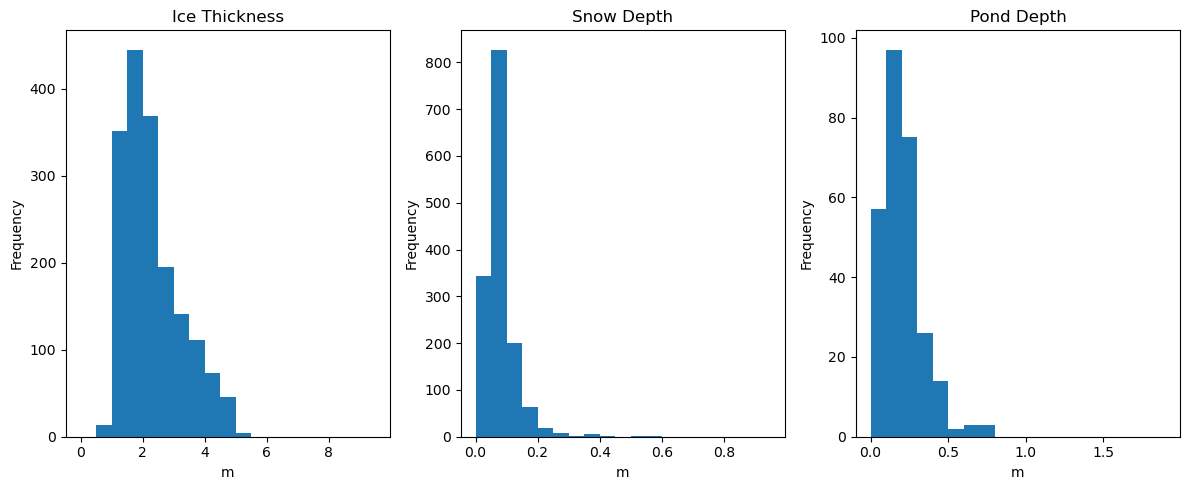

In [22]:
ice_bins = np.arange(0., 10., 0.5)
snow_bins = np.arange(0., 1., 0.05)
pond_bins = np.arange(0., 2., 0.1)

fig, ax = plt.subplots(1, 3, figsize=(12, 5))

df["ice_thickness_m"].plot(kind="hist", ax=ax[0], title="Ice Thickness", xlabel="m", bins=ice_bins)
df["snow_depth_m"][df.snow_depth_m > 0.].plot(kind="hist", ax=ax[1], title="Snow Depth", xlabel="m", bins=snow_bins)
df["melt_pond_depth_m"][df.melt_pond_depth_m > 0.].plot(kind="hist", ax=ax[2], title="Pond Depth", xlabel="m", bins=pond_bins)

fig.tight_layout()

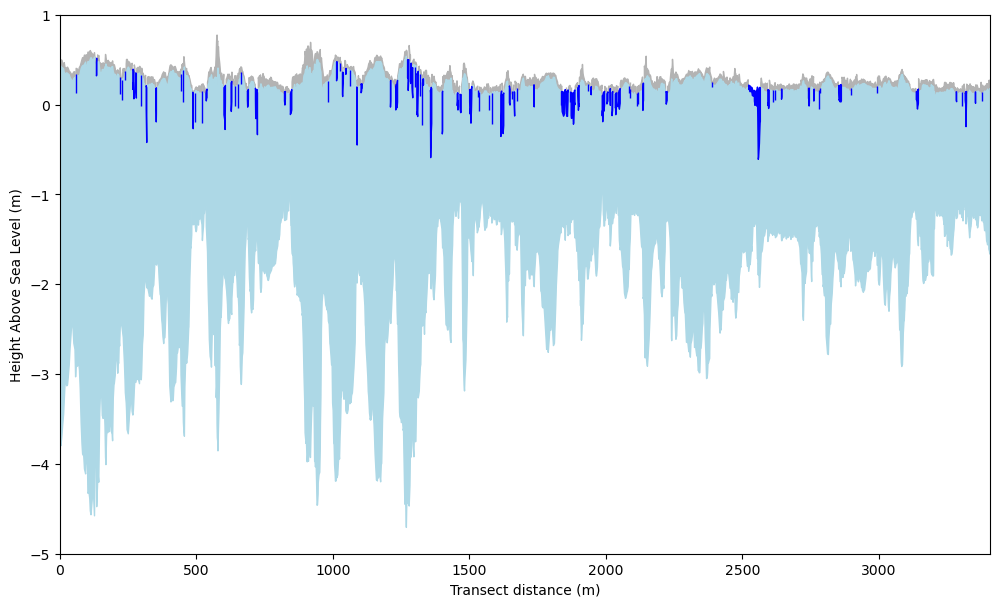

In [23]:
fig, ax = plt.subplots(figsize=(12,7))
plot_thickness_profile(df, ax=ax, snow_depth_exaggeration=1)

## Parse and write new files

In [44]:
def fix_transect_path(f):
    m = re.match(r"(\d{8})(PS122.+)", f.parts[-2])
    return '-'.join(m.groups())
    
p = re.compile(r"\d{8}-PS122-\d+_\d+-\d+")
for f in files:
    if not p.match(f.parts[-2]):
        transect_path = fix_transect_path(f)
    else:
        transect_path = f.parts[-2]

    outpath = Path(f.parents[3], "clean", f.parts[-3])

    try:
        df = parse_raw_combined_data(f)
    except Exception as err:
        print(err)
        continue
    
    outpath.mkdir(parents=True, exist_ok=True)
    df.to_csv(outpath /  f.name)

/home/apbarret/src/mosaic_sunlight_underseaice/notebooks/../mosaic_underice_sunlight/mosaic_thickness.py:154: UserWarning: melt_pond_depth_m not found in dataFrame; adding column of zeros
  warnings.warn("melt_pond_depth_m not found in dataFrame; adding column of zeros",
/home/apbarret/src/mosaic_sunlight_underseaice/notebooks/../mosaic_underice_sunlight/mosaic_thickness.py:132: UserWarning: Using ice_thickness_f18325hz_hcp_i_m for ice thickness
  warnings.warn("Using ice_thickness_f18325hz_hcp_i_m for ice thickness",
/home/apbarret/src/mosaic_sunlight_underseaice/notebooks/../mosaic_underice_sunlight/mosaic_thickness.py:154: UserWarning: melt_pond_depth_m not found in dataFrame; adding column of zeros
  warnings.warn("melt_pond_depth_m not found in dataFrame; adding column of zeros",
/home/apbarret/src/mosaic_sunlight_underseaice/notebooks/../mosaic_underice_sunlight/mosaic_thickness.py:132: UserWarning: Using ice_thickness_f18325hz_hcp_i_m for ice thickness
  warnings.warn("Using ice

index 1 is out of bounds for axis 0 with size 0


/home/apbarret/src/mosaic_sunlight_underseaice/notebooks/../mosaic_underice_sunlight/mosaic_thickness.py:154: UserWarning: melt_pond_depth_m not found in dataFrame; adding column of zeros
  warnings.warn("melt_pond_depth_m not found in dataFrame; adding column of zeros",
/home/apbarret/src/mosaic_sunlight_underseaice/notebooks/../mosaic_underice_sunlight/mosaic_thickness.py:132: UserWarning: Using ice_thickness_f18325hz_hcp_i_m for ice thickness
  warnings.warn("Using ice_thickness_f18325hz_hcp_i_m for ice thickness",
/home/apbarret/src/mosaic_sunlight_underseaice/notebooks/../mosaic_underice_sunlight/mosaic_thickness.py:154: UserWarning: melt_pond_depth_m not found in dataFrame; adding column of zeros
  warnings.warn("melt_pond_depth_m not found in dataFrame; adding column of zeros",
/home/apbarret/src/mosaic_sunlight_underseaice/notebooks/../mosaic_underice_sunlight/mosaic_thickness.py:154: UserWarning: melt_pond_depth_m not found in dataFrame; adding column of zeros
  warnings.warn(